In [1]:
import sys
if sys.argv[1] == 'xxx': pass
else: 
    %matplotlib inline

import os
import numpy
import pandas
import matplotlib
import matplotlib.pyplot
matplotlib.rcParams['font.family'] = 'Arial,freesans'

import necstdb

In [5]:
cwd = os.getcwd()
mode, date = cwd.split('/')[-2], cwd.split('/')[-1]

data_path = '/media/usbdisk/data/{mode}/{date}.necstdb'.format(**locals())

db = necstdb.opendb(data_path)

In [6]:
xffts_topics = [
        'xffts_power_board01',
        'xffts_power_board02',
        'xffts_power_board03',
        'xffts_power_board04',
        'xffts_power_board05', 
        'xffts_power_board06',
        'xffts_power_board07',
        'xffts_power_board08',
        'xffts_power_board09',
        'xffts_power_board10', 
        'xffts_power_board11',
        'xffts_power_board12',
        'xffts_power_board13', 
        'xffts_power_board14', 
        'xffts_power_board15',
        'xffts_power_board16',
]

hemt_topics = [
    'hemt_2l_vd',
    'hemt_2l_vg1',
    'hemt_2l_vg2',
    'hemt_2r_vd',
    'hemt_2r_vg1',
    'hemt_2r_vg2',
    'hemt_3l_vd',
    'hemt_3l_vg1',
    'hemt_3l_vg2',
    'hemt_3r_vd',
    'hemt_3r_vg1',
    'hemt_3r_vg2',
    'hemt_4l_vd',
    'hemt_4l_vg1',
    'hemt_4l_vg2',
    'hemt_4r_vd',
    'hemt_4r_vg1',
    'hemt_4r_vg2',
    'hemt_5l_vd',
    'hemt_5l_vg1',
    'hemt_5l_vg2',
    'hemt_5r_vd',
    'hemt_5r_vg1',
    'hemt_5r_vg2',    
]

In [7]:
xffts = {
    _: db.open_table(_).read(astype='array')
    for _ in xffts_topics
}

tp = {
    _: xffts[_]['total_power']
    for _ in xffts_topics
}

dt1 = {
    _: xffts[_]['timestamp'][1:] - xffts[_]['timestamp'][:-1]
    for _ in xffts_topics
}

dt2 = {
    _: xffts[_]['received_time'][1:] - xffts[_]['received_time'][:-1]
    for _ in xffts_topics
}

hemt = {
    _: db.open_table(_).read(astype='array')
    for _ in hemt_topics
}

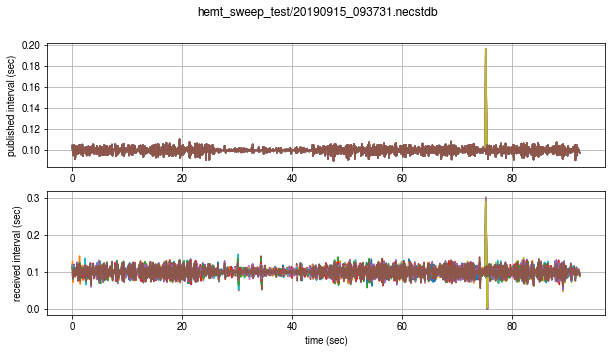

In [8]:
fig = matplotlib.pyplot.figure(figsize=(10,5))
ax = fig.add_subplot(2,1,1)
[ax.plot(xffts[_]['timestamp'][:-1] - xffts[_]['timestamp'][0], dt1[_]) for _ in xffts_topics]
ax.grid(True)
ax.set_ylabel('published interval (sec)')

ax = fig.add_subplot(2,1,2)
[ax.plot(xffts[_]['received_time'][:-1] - xffts[_]['received_time'][0], dt2[_]) for _ in xffts_topics]
ax.grid(True)
ax.set_xlabel('time (sec)')
ax.set_ylabel('received interval (sec)')

fig.suptitle(mode + '/' +date)
fig.savefig('t_interval.png')

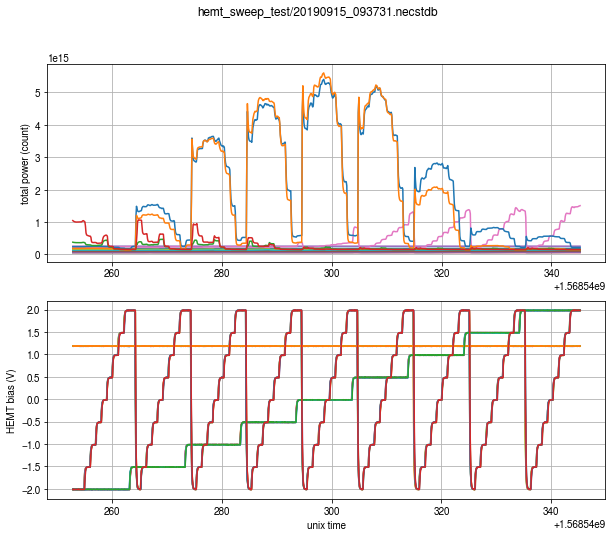

In [9]:
nrows = 2


fig = matplotlib.pyplot.figure(figsize=(10,8))

ax = fig.add_subplot(nrows,1,1)
[ax.plot(xffts[_]['timestamp'], tp[_]) for _ in xffts_topics]
ax.grid(True)
ax.set_ylabel('total power (count)')

ax = fig.add_subplot(nrows,1,2)
[ax.plot(hemt[_]['received_time'], hemt[_]['data']) for _ in hemt_topics]
ax.grid(True)
ax.set_ylabel('HEMT bias (V)')
ax.set_xlabel('unix time')

fig.suptitle(mode + '/' +date)
fig.savefig('t_topics.png')

In [10]:
xffts2hemt = {
        'xffts_power_board01': 'hemt_2l_vg',
        'xffts_power_board02': 'hemt_2l_vg',
        'xffts_power_board03': 'hemt_2r_vg',
        'xffts_power_board04': 'hemt_2r_vg',
        'xffts_power_board05': 'hemt_3l_vg',
        'xffts_power_board06': 'hemt_3l_vg',
        'xffts_power_board07': 'hemt_3r_vg',
        'xffts_power_board08': 'hemt_3r_vg',
        'xffts_power_board09': 'hemt_4l_vg',
        'xffts_power_board10': 'hemt_4l_vg',
        'xffts_power_board11': 'hemt_4r_vg',
        'xffts_power_board12': 'hemt_4r_vg',
        'xffts_power_board13': 'hemt_5l_vg',
        'xffts_power_board14': 'hemt_5l_vg',
        'xffts_power_board15': 'hemt_5r_vg',
        'xffts_power_board16': 'hemt_5r_vg',
}

In [11]:
df_ = {
    _ : pandas.concat(
        [
            pandas.DataFrame(
                hemt[xffts2hemt[_]+'1']['data'],
                index = pandas.to_datetime(hemt[xffts2hemt[_]+'1']['received_time'], unit='s'),
                columns = ['vg1'],
            ),

            pandas.DataFrame(
                hemt[xffts2hemt[_]+'2']['data'],
                index = pandas.to_datetime(hemt[xffts2hemt[_]+'2']['received_time'], unit='s'),
                columns = ['vg2'],
            ),

            pandas.DataFrame(
                xffts[_]['total_power'],
                index = pandas.to_datetime(xffts[_]['timestamp'], unit='s'),
                columns = ['tp'],
            ),
        ],

        axis = 1,
    )
    for _ in xffts_topics
}

df = {_ : df_[_].resample('0.1S').median() for _ in df_}

for _ in df:
    mask1 = (df[_]['vg1'][1:].values - df[_]['vg1'][:-1].values) < 0.01
    mask2 = (df[_]['vg2'][1:].values - df[_]['vg2'][:-1].values) < 0.01
    df[_] = df[_][:-1][mask1 & mask2]
    continue

/home/amigos/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less
/home/amigos/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


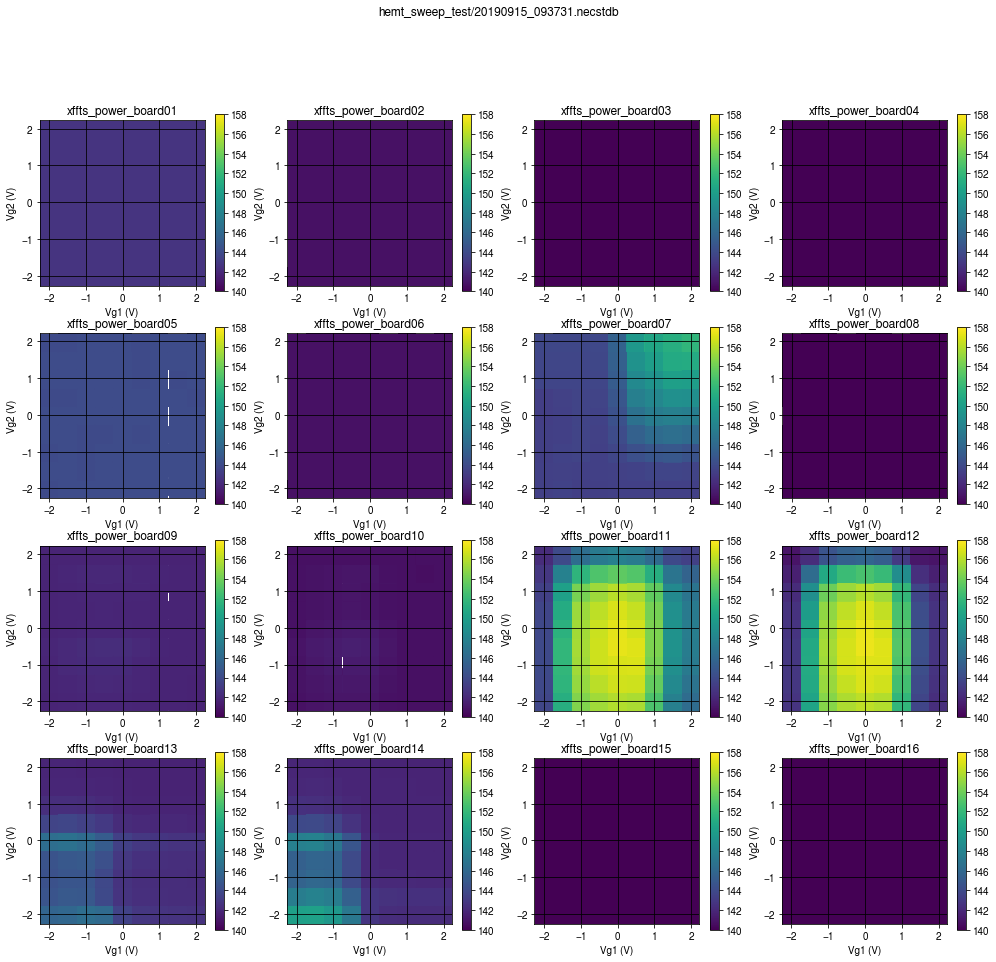

In [15]:
fig = matplotlib.pyplot.figure(figsize=(17, 15))
ax = [fig.add_subplot(4, 4, i, aspect=1) for i in range(1,17)]
cm = [
    _a.scatter(df[_]['vg1'], df[_]['vg2'], c=numpy.log10(df[_]['tp'])*10, marker='s', s=300, vmin=140, vmax=158) 
    for _a, _ in zip(ax, xffts_topics)
]
[fig.colorbar(_c, ax=_a) for _a, _c in zip(ax, cm)]
[_a.grid(True, color='k') for _a in ax]
[_a.set_xlabel('Vg1 (V)') for _a in ax]
[_a.set_ylabel('Vg2 (V)') for _a in ax]
[_a.set_title(_) for _, _a in zip(xffts_topics, ax)]
fig.suptitle(mode + '/' + date)
fig.savefig('hemt_v_sweep_power_map.png')